# Prendre en main l'API Python d'ArcGIS - épisode 3
## Métriques et Dashboard de supervision d'une organisation 

Dans ce troisième tutoriel de **[série de l'été consacrée à la prise en main de l'API Python d'ArcGIS](https://www.codethemap.fr/2024/05/prise-en-main-api-python-arcgis-intro.html)**, vous allez récupérer plusieurs données et métriques sur votre organisation et les publier pour créer un tableau de bord.  
Notez que vous aurez pour cela besoin d'un **compte administrateur** dans votre organisation ArcGIS Online ou ArcGIS Enterprise. 

### 1/ Import des bibliothèques et connexion au GIS

Nous commençons par importer les différentes bibliothèques nécessaires, puis par nous connecter au SIG.   
La connexion est à adapter selon votre environnement et votre méthode d'authentification. [Voir l'aide en ligne pour plus d'informations](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/).  
La cellule va peut-être vous renvoyer un message rouge pour vous prévenir que vous êtes connectés en tant qu'administrateur, et qu'il faut faire attention aux opérations que vous utilisez. Cela n'empêche pas votre code de s'exécuter correctement.

In [1]:
import datetime
import pandas as pd

from arcgis.gis import GIS

In [2]:
gis = GIS("home")

/opt/conda/lib/python3.11/site-packages/arcgis/gis/__init__.py:731: UserWarning: You are logged on as plouis_esrifrance with an administrator role, proceed with caution.
  warnings.warn(


#### Alternative pour la connexion si votre environnement n'est pas directement connecté à votre portail

In [ ]:
#à modifier avec vos propres informations d'authentification et l'url de votre portail
gis =GIS(
url="https://url.devotre.org/portal",
username="nom_utilisateur",
password="motdepasse"
)

### 2/ Récupération de la date du jour et de la date du premier jour du mois

Dans ce tutoriel, nous allons obtenir des informations sur notre organisation au global, mais nous allons également chercher à avoir des données spécifiques pour le mois en cours. Pour cela, nous utiliserons la bibliothèque [datetime](https://docs.python.org/fr/3/library/datetime.html). Cela nous permet d'obtenir la date du jour, la date du premier jour du mois, ainsi que la date du jour au format annee_mois_jour. Cette dernière nous servira  pour nommer les items que nous allons créer et sauvegarder dans la suite du script.

In [4]:
ajdh = datetime.datetime.now() #date d'ajourd'hui
premier_jour_mois = ajdh.replace(day=1) #premier jour du mois
date = ajdh.strftime("%Y_%m_%d") #date du jour formattée annee_mois_jour (ex : 2024_07_04)

### 3/ Nombre d'utilisateurs selon leur type de licence

Les premières métriques que nous allons récupérer concernent les utilisateurs de notre organisation. Nous allons commencer par utiliser la fonction `search()` de la classe [`UserManager`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#usermanager) de l'API, qui va nous renvoyer tous les utilisateurs de l'org dans une liste.

#### Recherche de tous les utilisateurs et calcul de leur nombre total

In [ ]:
utilisateurs = gis.users.search(max_users=10000) #recherche de tous les utilisateurs de l'organisation

Il est ensuite très simple d'obtenir le nombre total d'utilisateurs, en utilisant la fonction `len()` sur notre liste d'utilisateurs.

In [ ]:
nbre_utilisateurs = len(utilisateurs)

#### Calcul du nombre d'utilisateurs par type de licence (Viewer, Creator, GIS Professional) et du nombre d'utilisateurs actifs ce mois-ci

Nous aimerions maintenant avoir des informations plus précises sur ces utilisateurs, à savoir quel type de licence (Viewer, Creator, GIS Professional ou autre) est attribuée à combien d'utilisateurs, et combien d'utilisateurs ont été actifs dans le mois en cours. 
Pour cela, nous commencerons par initialiser les variables devant contenir le décompte à 0.  
Nous itérons ensuite dans la liste des utilisateurs, et nous accédons à la propriété `userLicenseTypeId` pour savoir si l'utilisateur est un Viewer, un Creator, un GIS Professional (nous avons ici regroupé Basic, Standard et Advanced mais il est possible de les décompter séparément), ou autre. Nous incrémentons alors le décompte correspondant de 1.  
Nous obtenons ensuite la date de dernière connexion de l'utilisateur grâce à sa propriété `lastLogin`. Celle-ci renvoie une valeur en milisecondes décomptées depuis le 1er janvier 1970 (c'est de l'[Heure Unix](https://fr.wikipedia.org/wiki/Heure_Unix)). Nous utilisons une fois de plus la bibliothèque datetime pour convertir cette heure Unix en heure UTC, et la comparer au premier jour du mois que nous avons récupéré plus tôt. Si la date de dernière connexion de l'utilisateur est supérieure à la date du premier jour du mois, c'est que l'utilisateur a été actif ce mois-ci et que nous pouvons incrémenter le compte d'utilisateurs actifs de 1.

In [5]:
#initialisation des variables
nbre_viewer = 0
nbre_creator = 0
nbre_gis_professional = 0
nbre_autres = 0
nbre_utilisateurs_actifs = 0

#itération dans la liste d'utilisateurs
for utilisateur in utilisateurs:
    
    role = utilisateur.userLicenseTypeId
    if role == "viewerUT":  # ID de rôle pour Viewer
        nbre_viewer += 1
    elif role == "creatorUT":  # ID de rôle pour Creator
        nbre_creator += 1
    elif role.startswith("GISProfessional"):  # ID de rôle pour GISProfessional Advanced, Basic et Standard
        nbre_gis_professional += 1
    else :
        nbre_autres += 1
        
    derniere_connexion = utilisateur.lastLogin   #date de dernière connexion de l'utilisateur (heure Unix)
    date_derniere_connexion = datetime.datetime.utcfromtimestamp(derniere_connexion / 1000) #conversion de l'Unix en datetime UTC
    if date_derniere_connexion > premier_jour_mois :
        nbre_utilisateurs_actifs += 1
            
#affichage des résultats
print(f"Nombre de Viewers : {nbre_viewer}")
print(f"Nombre de Creators : {nbre_creator}")
print(f"Nombre de GISProfessionals : {nbre_gis_professional}")
print(f"Nombre d'autres : {nbre_autres}")
print(f"Nombre total d'utilisateurs : {nbre_utilisateurs}")
print(f"Nombre d'utilisateurs actifs ce mois : {nbre_utilisateurs_actifs}")

Nombre de Viewers : 6
Nombre de Creators : 163
Nombre de GISProfessionals : 90
Nombre d'autres : 9
Nombre total d'utilisateurs : 268
Nombre d'utilisateurs actifs ce mois : 140


#### Publication des données en tant que service de table hébergé

Ces données se suffisent si elles sont uniquement destinées à être lues dans ce Notebook au moment de son exécution. Cependant, je vais vous montrer comment les publier en tant que table hébergée. Cela nous permettra de les utiliser pour en faire un Dashboard.  
Afin de publier les donnée, nous allons suivre 4 étapes : 
- création d'un dataframe contenant les données ; 
- transformation du dataframe en CSV 
- ajout du CSV au contenu de notre portail ;
- publication du CSV en tant que service.

##### Création d'un dataframe contenant les données

Commençons par écrire les données sous forme de dataframe grâce à la bibliothèque pandas que nous avons déjà utilisée lors des précédents tutoriels de cette série. Pour cela, nous utilisons la fonction [`Dataframe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). En exécutant la cellule, vous pouvez voir à quoi ressemble ce dataframe.

In [6]:
#création du dictionnaire avec les métriques récupérées précédemment
donnees_utilisateurs = {
    'Utilisateurs': ['Viewers','Creators','GIS Professionals', 'Autres','Total','Actifs'],
    'Nombre': [nbre_viewer,nbre_creator,nbre_gis_professional,nbre_autres,nbre_utilisateurs,nbre_utilisateurs_actifs]
}

#transformation du dictionnaire en dataframe avec la bibliothèque pandas (pd)
df_utilisateurs= pd.DataFrame(donnees_utilisateurs)
df_utilisateurs

,Utilisateurs,Nombre
0,Viewers,6
1,Creators,163
2,GIS Professionals,90
3,Autres,9
4,Total,268
5,Actifs,140


##### Transformation du dataframe en CSV 

Passons à la deuxième étape, où nous utilisons la fonction [`to_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html) afin de transformer le dataframe en CSV. Notez que nous déclarons dans une variable le nom du CSV, en y concaténant la date du jour récupérée au début du Notebook. Ainsi, si vous éxécutez le Notebook une fois par mois, vous n'aurez pas de conflit avec les données publiées les mois précédents.

In [ ]:
nom_csv_utilisateurs = f"csv_nombre_utilisateurs_{date}"
fichier_csv_utilisateurs = df_utilisateurs.to_csv(nom_csv_utilisateurs)

##### Ajout du CSV au contenu du portail

Nous ajoutons ensuite ce CSV au contenu de notre portail grâce à la méthode `add()` de la classe [`ContentManager`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#contentmanager) de l'API.

In [ ]:
item_csv_utilisateurs = gis.content.add({'type':'CSV','title':f"Nombre d'utilisateurs {date}"}, nom_csv_utilisateurs)

Si vous inspectez votre contenu, vous devriez voir le CSV apparaître :

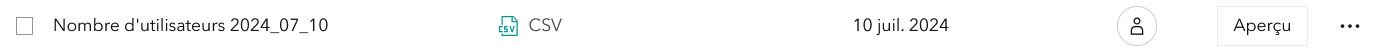

##### Publication du CSV en tant que service

Enfin, ce CSV doit être publié en tant que service de table pour pouvoir être facilement être utilisé dans votre SIG. La méthode [`publish()`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.publish) de la classe [`Item`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#item) permet justement de publier des services hébergés à partir d'un item source, ici notre CSV. 

In [7]:
lyr_csv_utilisateurs = item_csv_utilisateurs.publish()
lyr_csv_utilisateurs

<Item title:"Nombre d'utilisateurs 2024_07_10" type:Table Layer owner:plouis_esrifrance>

Le service de table est maintenant publié dans votre contenu :   
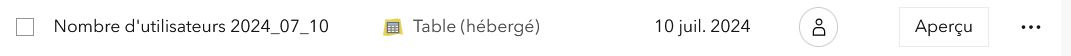

### 4/ Historique des actions des utilisateurs

Le module [`arcgis.gis.admin`](https://developers.arcgis.com/python/api-reference/arcgis.gis.admin.html) de l'API nous permet d'accéder à la méthode [`history()`](https://developers.arcgis.com/python/api-reference/arcgis.gis.admin.html?#arcgis.gis.admin.AGOLAdminManager.history). Celle-ci retourne un fichier CSV contenant un historique d'action de tous les utilisateurs. Nous utilisons ensuite la fonction read_csv() de la bibliothèque pandas pour pouvoir manipuler ce CSV très dense et le rendre plus lisible. Nous pouvons par exemple filtre le type d'action pour ne pas prendre en compte les login, puis nous affichons les données sous forme de diagramme.

<AxesSubplot: xlabel='action'>

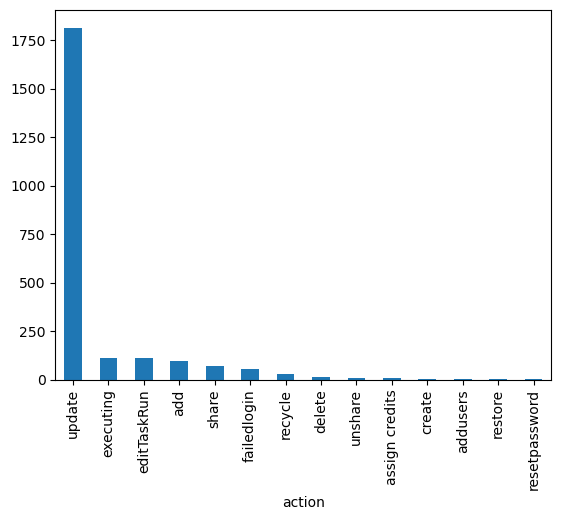

In [8]:
csv_historique_actions = gis.admin.history(start_date = premier_jour_mois, to_date = ajdh, num=-1)
df_historique = pd.read_csv(csv_historique_actions)
df_filtre = df_historique[df_historique.action !='login']
df_filtre.action.value_counts().plot.bar()

#### Publication des données en tant que service de table hébergé

Comme tout à l'heure, nous allons publier les données en tant que service de table, en suivant les 4 mêmes étapes que tout à l'heure. Nous créons pour cela un dataframe qui ne contient que les données qui seront utiles pour afficher le diagramme dans un tableau de bord. Nous le transformons ensuite en CSV, que nous ajoutons à notre portail avant de le publier en tant que table. 

In [9]:
df_final = df_filtre[["action","id"]]
nom_csv_actions = f"csv_historique_actions_{date}"
fichier_csv_actions = df_final.to_csv(nom_csv_actions)
item_csv_actions = gis.content.add({'type':'CSV','title':f"Historique d'actions des utilisateurs {date}"}, nom_csv_actions)
lyr_csv_actions=item_csv_actions.publish()
lyr_csv_actions

<Item title:"Historique d'actions des utilisateurs 2024_07_10" type:Table Layer owner:plouis_esrifrance>

### Rapport sur les contenus

#### Création et lecture du rapport

La méthode [`report()`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.User.report) permet d'obtenir divers rapport sur l'utilisation de votre organisation. Cela peut par exemple être sur les crédits, comme nous l'avons vu [lors du tuto numéro 2](https://www.codethemap.fr/2024/07/admin-credits-tache-notebook-api-python-arcgis.html), ou encore sur le contenu, les utilisateurs, l'utilisation des services et des items... Pour tester les différents types de rapports, il suffit de changer la valeur du paramètre `report_type`. Ici, nous allons générer un rapport sur les contenus. 

In [10]:
rapport_contenus = gis.users.me.report(report_type = "content")

`start_time` is not honored with report type of content and users.


Un rapport administratif a été ajouté à vos contenus :  
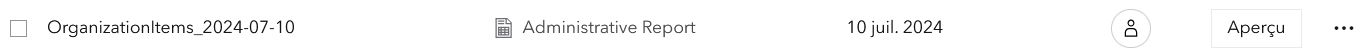

Nous allons maintenant lire le contenu de ce rapport dans un dataframe.

In [11]:
fichier_rapport_contenus = rapport_contenus.get_data()

# Convertir les données en DataFrame
df_contenu = pd.read_csv(fichier_rapport_contenus)
df_contenu.head()

,Title,Item ID,Item Url,Item Type,Date Created,Date Modified,Content Category,View Counts,Owner,File Storage Size,Feature Storage Size,Share Level,# of Groups shared with,Tags,Number of Comments,Is Hosted Service,Date Last Viewed,In Recycle Bin
0,\t Zone de chalandise 15 minutes LeroyMerlin,308a1d29541d4c52a1755e6f99dbf43c,NaN,Web Map,2018-01-02 08:06:35,2018-01-02 14:50:40,NaN,104,llepiller_esrifrance,0.01860,0.0,private,0,map,0,False,2024-07-10 13:00:00,No
1,AUSTRALIA,e4618c608ece4176a0f97b096fc405f2,NaN,StoryMap,2023-12-29 16:02:32,2023-12-29 16:18:07,NaN,0,frochette_esrifrance,0.21999,0.0,private,0,NaN,0,False,NaN,No
2,Des informations pertinentes ...,1f7ed5d7832e41ca8f620448983ea3f5,https://storymaps.arcgis.com/stories/1f7ed5d78...,StoryMap,2020-02-26 09:06:27,2020-02-28 16:24:20,NaN,303,spaillard_esrifrance,17.81970,0.0,private,0,[],0,False,NaN,No
3,Établissements d'enseignement supérieur,dcde1fdedea942d288a0e0817a8b46e5,https://services.arcgis.com/d3voDfTFbHOCRwVR/a...,Feature Service,2018-03-02 09:51:59,2019-02-01 13:46:03,NaN,17720,Esri_France_Content,0.00000,0.5,public,13,"[ArcGIS, Service Definition, .sd, Établissemen...",0,True,2024-07-10 13:00:00,No
4,BAN_France,031b17d6a26a44b5bcda6d877c2df283,https://services.esrifrance.fr/arcgis/tokenacc...,Geocoding Service,2022-06-22 15:06:18,2022-06-22 15:06:19,NaN,0,jequey_esrifrance,0.00020,0.0,private,0,NaN,0,False,NaN,No


#### Récupération des métriques

Ce rapport contient beaucoup de données intéressantes. Pour ce tutoriel, nous allons nous contenter de récupérer 4 métriques : le nombre d'items total, le nombre d'items créés pour le mois en cours, la taille de stockage totale des items et la taille de stockage des items créés durant le mois en cours.  
- Il est très simple d'obtenir le nombre total d'items, en utilisant la fonction [`shape()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html) du dataframe. Celle-ci nous renvoie un tuple des dimensions du dataframe, sous la forme (nombre de lignes, nombre de colonnes). shape([0]) nous renvoie ainsi uniquement le nombre de lignes, ce qui nous permet d'obtenir le nombre total d'enregistrements dans le dataframe, c'est-à-dire le nombre d'items dans notre organisation.

In [ ]:
#obtention du nombre d'items total
nbre_items_crees_total = df_contenu.shape[0]

- Pour obtenir le nombre d'items pour le mois en cours, nous commençons par convertir la colonne 'Date Created' de notre dataframe en datetime avec la fontion [`to_datetime()`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html). Il est ensuite possible de créer un nouveau dataframe qui filtre uniquement les items créés après la date du premier jour du mois. Enfin, nous réutilisons la fonction `shape()` pour obtenir le nombre d'items dans ce nouveau dataframe.

In [ ]:
#convertion de la colonne 'Date Created' en datetime
df_contenu['Date Created'] = pd.to_datetime(df_contenu['Date Created'], errors='coerce')

#filtre des items uniquement pour le mois en cours
item_crees_mois = df_contenu[(df_contenu['Date Created'] >= premier_jour_mois)]

#obtention du nombre d'items créés durant le mois en cours
nbre_item_crees_mois = item_crees_mois.shape[0]

- Pour les tailles de stockage, il suffit d'additionner avec la fonction `sum()` les colonnes File Storage Size, d'une part du dataframe complet et d'autre part du dataframe filtré sur le mois en cours. Grâce à la fonction `round()`, nous arrondissons à 2 chiffres après la virgule.

In [ ]:
#obtention des tailles de stockage pour le mois en cours et pour les items créés ce mois
taille_stockage_totale = round(df_contenu['File Storage Size'].sum(),2)
taille_stockage_mois = round(item_crees_mois['File Storage Size'].sum(),2)

Nous pouvons désormais imprimer toutes nos trouvailles :

In [12]:
#affichage des résultats
print(f"Nombre d'items total dans l'org: {nbre_items_crees_total}")
print(f"Nombre d'items créés sur le mois en cours: {nbre_item_crees_mois}")
print(f"Total File Storage Size pour tous les items : {taille_stockage_totale} MB")
print(f"Total File Storage Size pour les items créés ce mois-ci : {taille_stockage_mois} MB")

Nombre d'items total dans l'org: 51055
Nombre d'items créés sur le mois en cours: 310
Total File Storage Size pour tous les items : 6191898.76 MB
Total File Storage Size pour les items créés ce mois-ci : 61789.59 MB


#### Publication des données en tant que service de table hébergé

Comme lors des deux différentes étapes, nous publions les données obtenues sous forme de service de table hébergé.

In [13]:
donnees_items = {
    'Item': ["Nombre total d'items","Nombre d'items créés ce mois",'Stockage total', 'Stockage des items créés ce mois'],
    'Nombres': [nbre_items_crees_total,nbre_item_crees_mois,taille_stockage_totale,taille_stockage_mois]
}

df_items= pd.DataFrame(donnees_items)
df_items

,Item,Nombres
0,Nombre total d'items,51055.00
1,Nombre d'items créés ce mois,310.00
2,Stockage total,6191898.76
3,Stockage des items créés ce mois,61789.59


In [14]:
nom_csv_items = f"csv_items_{date}"
fichier_csv_items = df_items.to_csv(nom_csv_items)
item_csv_items = gis.content.add({'type':'CSV','title':f"Information stockage items {date}"}, nom_csv_items)
lyr_csv_items=item_csv_items.publish()
lyr_csv_items

<Item title:"Information stockage items 2024_07_10" type:Table Layer owner:plouis_esrifrance>

### Validation des métadonnées

#### Recherche du contenu créé ce mois-ci

La méthode [`search()`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.search=) appliquée à la classe `ContentManager` retourne le contenu de notre organisation sous la forme d'une liste. A l'intérieur de celle-ci, nous passons en argument une query qui nous permet de récupérer uniquement le contenu ayant été créé entre le premier jour du mois et aujourd'hui.

In [15]:
contenu = gis.content.search(query = "created: ["+str(int(premier_jour_mois.timestamp()*1000))+" TO "+str(int(ajdh.timestamp()*1000))+"]",max_items = -1)

#### Vérification de la complétion des métadonnées

Nous allons maintenant itérer parmi tous les items de cette liste un à un, pour vérifier si les métadonnées ont bien été complétées.  
Les [items](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#item) possèdent un certain nombre de propriétés relatives à leurs métadonnées (titre, description, miniature, tags, ...), que nous pouvons requêter pour savoir si elles ont été complétées ou non. La liste complète des propriétés accessibles pour les items est disponible dans la documentation de l'[API REST](https://developers.arcgis.com/rest/users-groups-and-items/item/#response-properties).
Ci-dessous, grâce à la fonction `len()` nous récupérons le nombre total d'items renvoyés par la fonction `search()` précedemment. Puis, pour chaque item, nous vérifions une à une chacune des métadonnées. Si toutes les métadonnées sont complètes, nous incrémentons le décompte de métadonnées complètes de 1. 

In [16]:
df_metadonnees = pd.DataFrame(columns=["title", "itemid", "description", "snippet", "tags", "thumbnail","owner","status"])
nbre_total_items = len(contenu)
nbre_metadonnees_completes = 0

for item in contenu :
    title = item.title
    itemid = item.id 
    if item.description :
        description_val = True
    else :
        description_val = True
    if item.snippet :
        snippet_val = True
    else :
        snippet_val = False
    if len((item.tags))>0:
        tags_val = True
    else : 
        tags_val = False
    if item.thumbnail :
        thumbnail_val = True
    else :
        thumbnail_val = False
    owner = item.owner
    
    if description_val and snippet_val and tags_val and thumbnail_val:
        nbre_metadonnees_completes += 1
        status = "Métadonnées complètes"
    else :
        status = "Métadonnées incomplètes"
        
    nouvelle_ligne = {"title": title, "itemid": itemid, "description": description_val, "snippet": snippet_val, "tags": tags_val, "thumbnail": thumbnail_val, "owner": owner, "status":status}
    df_metadonnees = pd.concat([df_metadonnees, pd.DataFrame([nouvelle_ligne])], ignore_index=True)   
        
df_metadonnees.head()

,title,itemid,description,snippet,tags,thumbnail,owner,status
0,ETAT DES LIEUX DU DRONATHLON,df65590f9c524c9d84f24b0f39421b5a,True,False,True,True,rlabellerojoux_esrifrance,Métadonnées incomplètes
1,Sentinelle_de_randonn_e_sampleTemplateSummary_(1),f5d039aa31fe407881ab7360a59965f0,True,True,True,False,hgaignard,Métadonnées incomplètes
2,Sentinelle_de_randonn_e_sampleTemplateSummary,8a3967aeea38481a9d00ec0ffcd01337,True,True,True,False,hgaignard,Métadonnées incomplètes
3,Intégration Survey123 dans Experience Builder ...,c040000e5d0f41148df9fe33f1cd3205,True,False,False,True,plouis_esrifrance,Métadonnées incomplètes
4,SIG2024_Docks_3D_WSL1,cb94d307f7494027bf2b429706e2b26a,True,False,True,True,sgerland_esrifrance,Métadonnées incomplètes


Finalement, il est assez simple d'obtenir le pourcentage d'items créés ce mois-ci pour lequel les métadonnées sont complétées, en comparant le nombre d'items pour lequel les métadonnées sont complète au nombre total d'items.  
Imprimons le résultat, mais je vous préviens, il n'est en général pas glorieux... (à moins que vous ne travailliez avec des cracks des métadonnées, mais ce n'est a priori pas mon cas 👀)

In [17]:
pourcentage_metadonnees_completes = round((nbre_metadonnees_completes / nbre_total_items) * 100,2)
print("Pourcentage d'éléments avec des métadonnées complètes:", pourcentage_metadonnees_completes)

Pourcentage d'éléments avec des métadonnées complètes: 10.48


#### Publication des données en tant que service de table hébergé

Pour la dernière fois aujourd'hui, nous publions le résultat sur notre portail.

In [18]:
donnees = {
    'Statut': ['Completes'],
    'Pourcentage': [pourcentage_metadonnees_completes]
}

df_metadonnees = pd.DataFrame(donnees)
df_metadonnees

,Statut,Pourcentage
0,Completes,10.48


In [19]:
nom_csv_metadonnees = f"csv_metadonnees_{date}"
fichier_csv_metadonnees = df_metadonnees.to_csv(nom_csv_metadonnees)
item_csv_metadonnees = gis.content.add({'type':'CSV','title':f'Pourcentage de métadonnées complétées {date}'}, nom_csv_metadonnees)
lyr_csv_metadonnees = item_csv_metadonnees.publish()
lyr_csv_metadonnees

<Item title:"Pourcentage de métadonnées complétées 2024_07_10" type:Table Layer owner:plouis_esrifrance>

### Affichage dans un Dashboard

Avec ArcGIS Dashboards, vous pouvez utiliser tous les services de table que nous avons publiés précédemments pour créer facilement un tableau de bord compilant toutes les métriques que nous avons obtenues. Voici par exemple celui que j'ai réalisé pour mon organisation :  
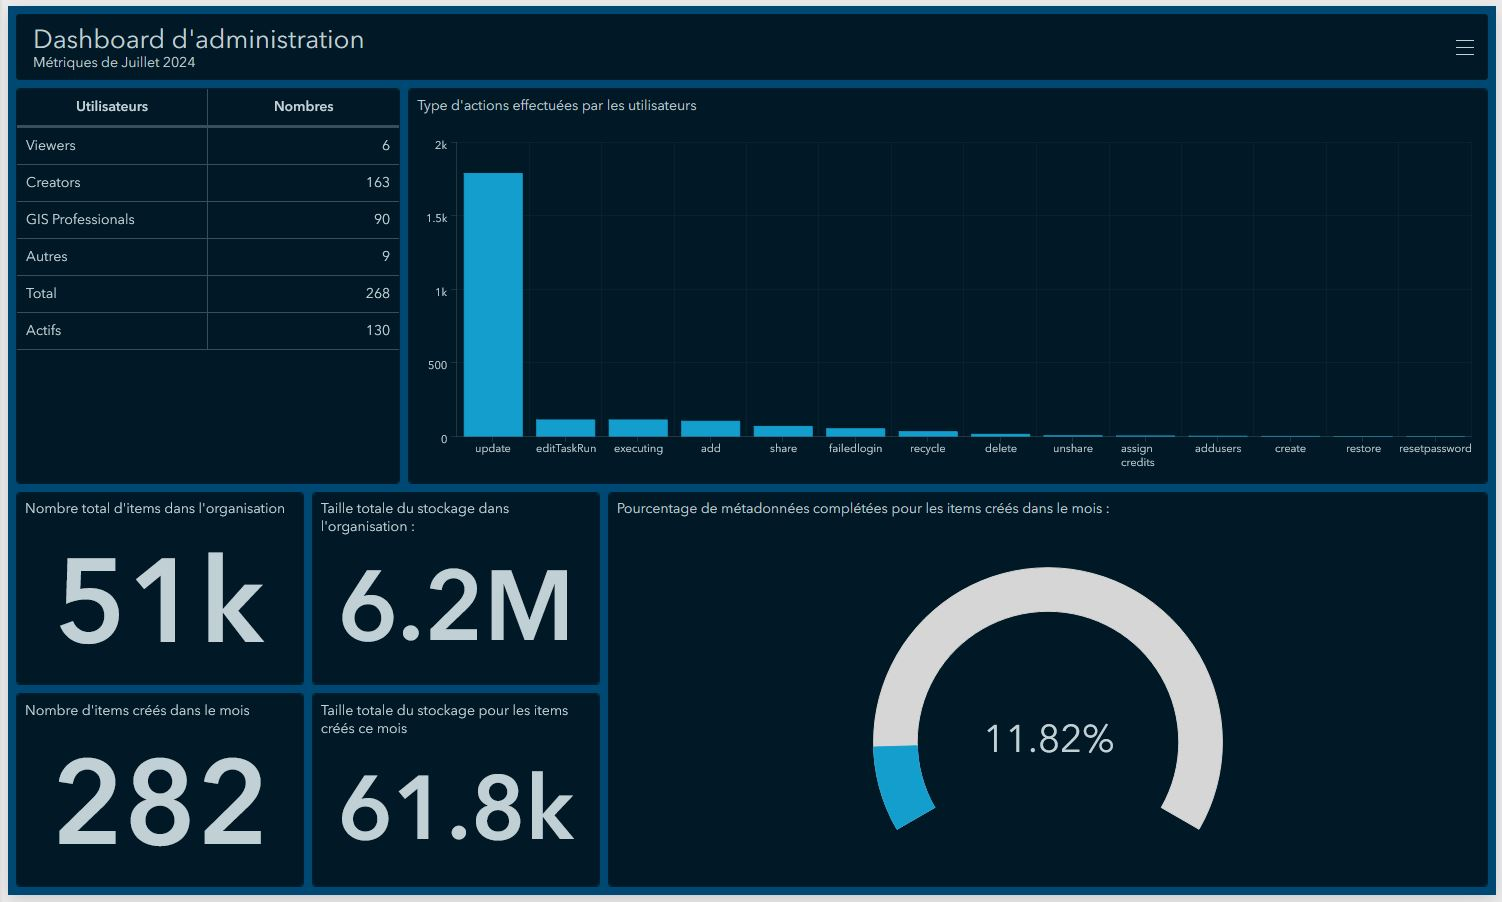

Cependant, il existe plusieurs manières d'automatiser ce processus :
- Premièrement, en utilisant le module [`arcgis.apps.dashboard`](https://developers.arcgis.com/python/api-reference/arcgis.apps.dashboard.html) pour créer de zéro un tout nouveau Dashboard. 
- La seconde option est de créer un Dashboard contenant déjà tous les indicateurs et qui servira de modèle. Vous pouvez ensuite mettre à jour les données contenues dans le Dashboard modèle avec les résultats de votre script.  

La deuxième méthode demandant plus de préparation, nous allons nous contenter de la première pour aujourd'hui. Notez cependant que l'API n'automatise pour l'instant que les Dashboards classiques, qui sont désormais dépréciés. Certaines fonctionnalités ne fonctionnant plus que partiellement, nous allons simplement afficher nos résultats sous forme de texte sans utiliser de diagrammes.

#### Import des éléments du Dashboard

Commençons par importer tous les modules spécifiques à la création d'un Dashboard via l'API.

In [20]:
from arcgis.apps.dashboard import Dashboard
from arcgis.apps.dashboard import Header, RichText
from arcgis.apps.dashboard import add_row, add_column

#### Entête (Header)

Le [Header](https://developers.arcgis.com/python/api-reference/arcgis.apps.dashboard.html#header) est assez simple a construire, et tous ses paramètres sont facultatifs. Ici, nous renseignons un titre, un sous-titre, une taille ainsi qu'un logo. Nous faisons en sorte que le nom du portail analysé soit affiché dans le titre en y accédant grâce à la propriété [`properties`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.GIS.properties) du [`GIS`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#gis). Nous ajoutons aussi le nom du mois en toutes lettres dans le sous-titre, ce qui nous demande un petit effort de traduction.

In [21]:
mois_fr = {
    "January": "janvier",
    "February": "février",
    "March": "mars",
    "April": "avril",
    "May": "mai",
    "June": "juin",
    "July": "juillet",
    "August": "août",
    "September": "septembre",
    "October": "octobre",
    "November": "novembre",
    "December": "décembre"
}

mois = ajdh.strftime("%B %Y")

# Remplacer le nom du mois anglais par sa traduction en français
for mois_anglais, mois_francais in mois_fr.items():
    mois = mois.replace(mois_anglais, mois_francais)
    
nom_portail = gis.properties["name"]

#entête
entete = Header(title=f"Synthèse - administration de l'organisation {nom_portail}",
                subtitle='Mois de {0}'.format(mois),
                margin=True,
                logo_image_url = "https://www.esrifrance.fr/iso_album/esri_france_emblem_tag_srgbrev.png", # a remplacer par votre logo
                size='large')

#### Création des indicateurs

Pour les indicateurs, nous allons utiliser la classe [`RichText`](https://developers.arcgis.com/python/api-reference/arcgis.apps.dashboard.html#richtext) qui nous permet d'ajouter du texte au tableau de bord, en accédant à toutes les variables calculées précedemment dans le Notebook. Notez que le texte prend en charge le formattage HTML.

In [22]:
membres = RichText(f"<h2>Nombre d'utilisateurs :</h2><br><h2><b>{nbre_utilisateurs}</b></h2>")
membres_actifs = RichText(f"<h2>Utilisateurs actifs ce mois :</h2><br><h2><b>{nbre_utilisateurs_actifs}</b></h2>")
licences = RichText(f"<h2>Répartition des licences : </h2><br><h3>Viewers : <b>{nbre_viewer}</b></h3><br><h3>Creator : <b>{nbre_creator}</b></h3><br><h3>GIS Professionals : <b>{nbre_gis_professional}</b></h3><br><h3>Autres : <b>{nbre_autres}</b></h3>")


items = RichText(f"<h2>Nombre d'items dans l'organisation :</h2><br><h2><b>{nbre_items_crees_total}</b></h2>")
items_created = RichText(f"<h2>Nombre d'items créés dans le mois :</h2><br><h2><b>{nbre_item_crees_mois}</b></h2>")

stockage = RichText(f"<h2>Stockage total :</h2><br><h2><b>{taille_stockage_totale} MB</b></h2>")
stockage_created =RichText(f"<h2>Stockage pour les items créés dans le mois :</h2><br><h2><b>{taille_stockage_mois} MB</b></h2>")

metadonnees = RichText(f"<h2>Pourcentage d'items créés dans le mois dont les métadonnées sont complètes :</h2><h2><b>{pourcentage_metadonnees_completes}%</b></h2>")

#### Création et sauvegarde du Dashboard

La dernière étape est de créer une instance de [`Dashboard`](https://developers.arcgis.com/python/api-reference/arcgis.apps.dashboard.html#arcgis.apps.dashboard.Dashboard). Nous pouvons paramétrer son entête en lui passant le header que nous avons construit en premier, puis choisir le thème (ici, sombre). Ensuite, nous ajoutons les lignes et les colonnes qui contiendront chacun des indicateurs que nous avons créés. Enfin, nous sauvegardons le dashboard qui va s'ajouter en tant que nouvel item à notre portail.

In [23]:
#création et sauvegarde du Dashboard
dashboard = Dashboard()
dashboard.header = entete
dashboard.theme = "dark"
dashboard.layout = add_row([add_column([add_row([membres,membres_actifs]),licences]),add_column([add_row([items,items_created]),add_row([stockage,stockage_created,metadonnees])])])

dashboard.save('Dashboard admin'.format(),
                description="résultat admin",
                tags='admin',
                overwrite=True)

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3553: DeprecatedWarning: Dashboard is deprecated as of 2.0.1.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
The `overwrite` parameter is no longer support on adding of items.


<Item title:"Dashboard admin" type:Dashboard owner:plouis_esrifrance>

Voici le résultat que vous devriez obtenir, avec vos propres indicateurs :  
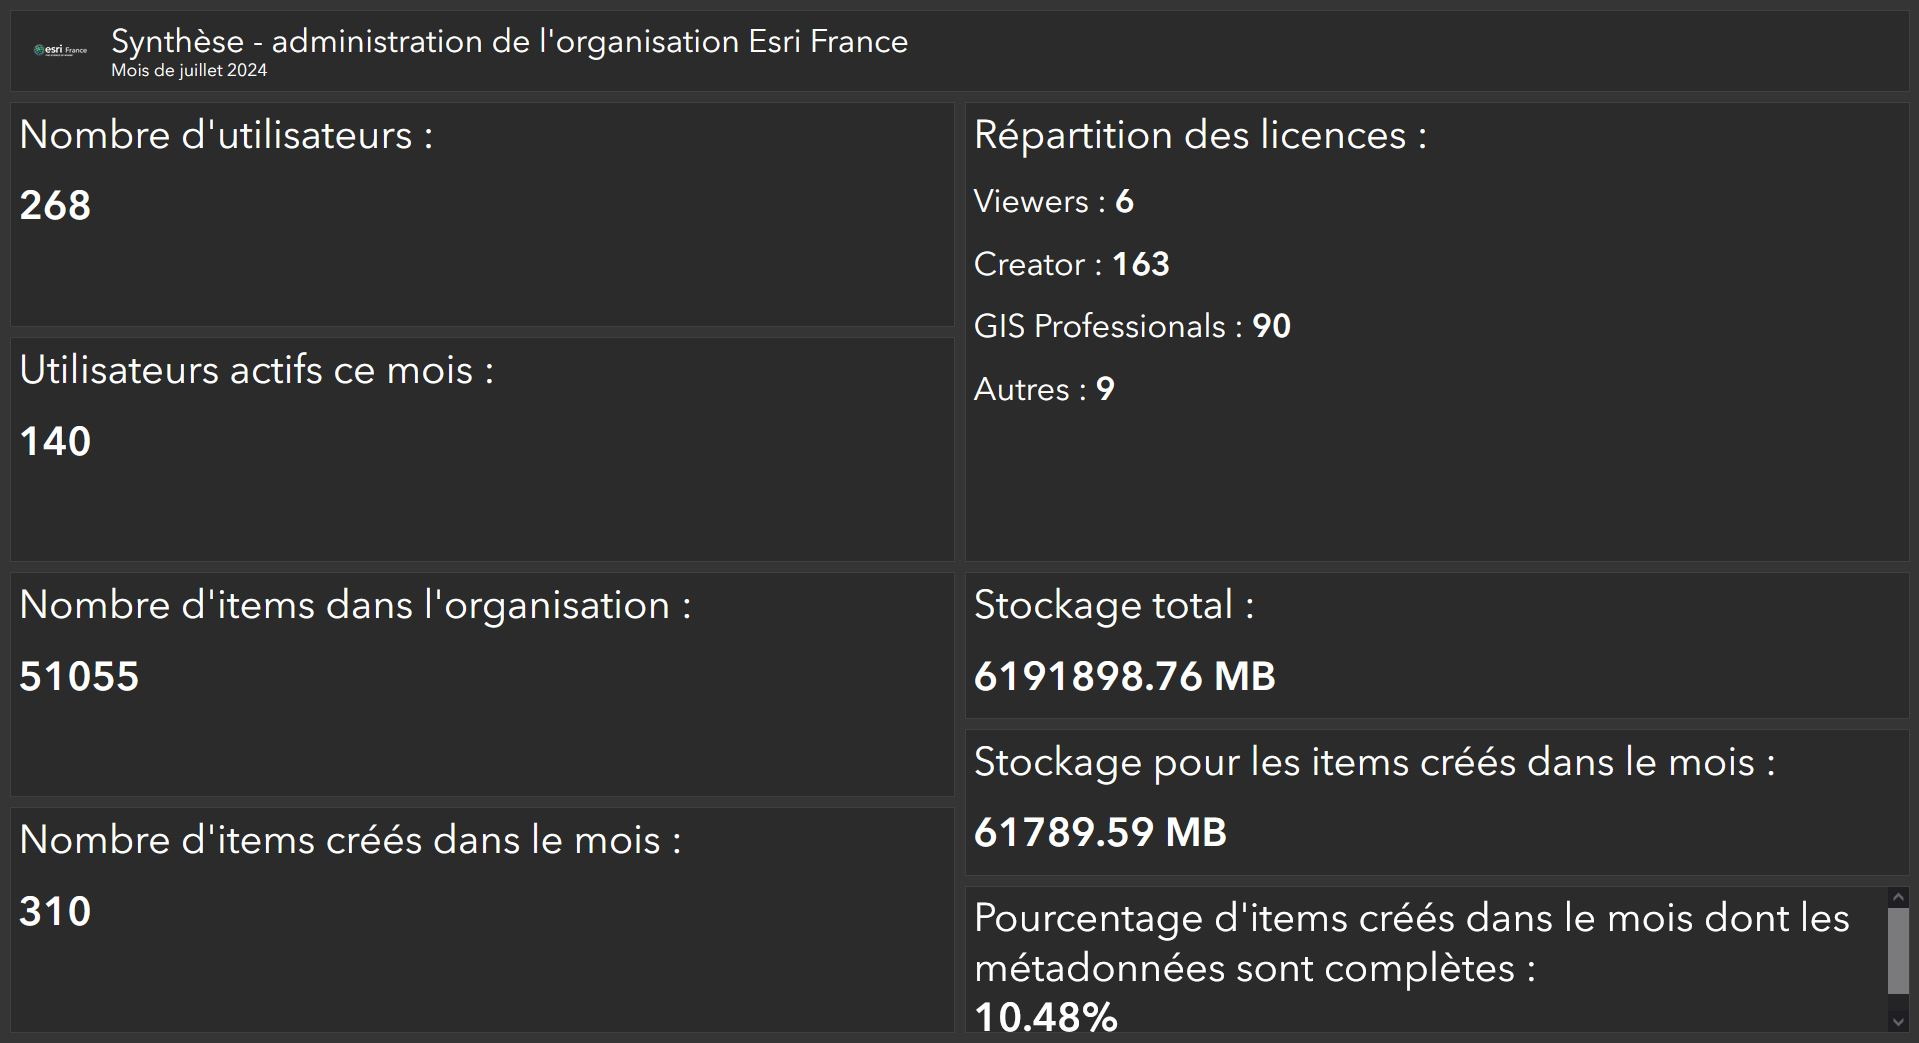